<a href="https://colab.research.google.com/github/Darren7-pixel/UTS_Kelompok_Deteksi_Alat_Makan/blob/main/UTS_Kelompok_Deteksi_Alat_Makan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# Install dependencies dan import libaries

!pip install ultralytics
!pip install roboflow
import os
import random
import shutil
from roboflow import Roboflow
from ultralytics import YOLO

In [26]:
# Connect ke Roboflow dan download dataset
rf = Roboflow(api_key="yt1OODHUCexaYBxopj2F")
project = rf.workspace("evan-wzedx").project("deteksi-alat-makan-1ojxi")
version = project.version(1)

# Download dataset YOLOv8, otomatis split jika belum ada
dataset = version.download("yolov8")
print(f"Dataset berhasil di-download ke: {dataset.location}")

# Path folder
train_img_folder = os.path.join(dataset.location, "train/images")
train_label_folder = os.path.join(dataset.location, "train/labels")
valid_img_folder = os.path.join(dataset.location, "valid/images")
valid_label_folder = os.path.join(dataset.location, "valid/labels")

loading Roboflow workspace...
loading Roboflow project...
Dataset berhasil di-download ke: /content/Deteksi-Alat-Makan-1


In [28]:
# Cek folder validasi kosong, kalau iya copy 20% train ke valid
if len(os.listdir(valid_img_folder)) == 0:
    print("Folder validasi kosong. Memindahkan 20% gambar dari train ke valid...")

    os.makedirs(valid_img_folder, exist_ok=True)
    os.makedirs(valid_label_folder, exist_ok=True)

    all_images = os.listdir(train_img_folder)
    num_valid = max(1, int(0.2 * len(all_images)))  # minimal 1 gambar
    valid_images = random.sample(all_images, num_valid)

    for img_name in valid_images:
        # Copy image
        shutil.copy(os.path.join(train_img_folder, img_name), os.path.join(valid_img_folder, img_name))
        # Copy label
        label_name = img_name.rsplit('.',1)[0] + ".txt"
        shutil.copy(os.path.join(train_label_folder, label_name), os.path.join(valid_label_folder, label_name))

    print(f"{len(valid_images)} gambar berhasil dicopy ke folder validasi.")
else:
    print("Folder validasi sudah berisi gambar.")



Folder validasi sudah berisi gambar.


In [33]:
model = YOLO("yolov8s.pt")
results = model.train(
    data=os.path.join(dataset.location, "data.yaml"),  # path ke data.yaml
    epochs=30,
    batch=8,
    imgsz=250,
    name="deteksi_alat_makan_train_auto",
    project="runs/detect",
    exist_ok=True,
)

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Deteksi-Alat-Makan-1/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=250, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=deteksi_alat_makan_train_auto, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, 

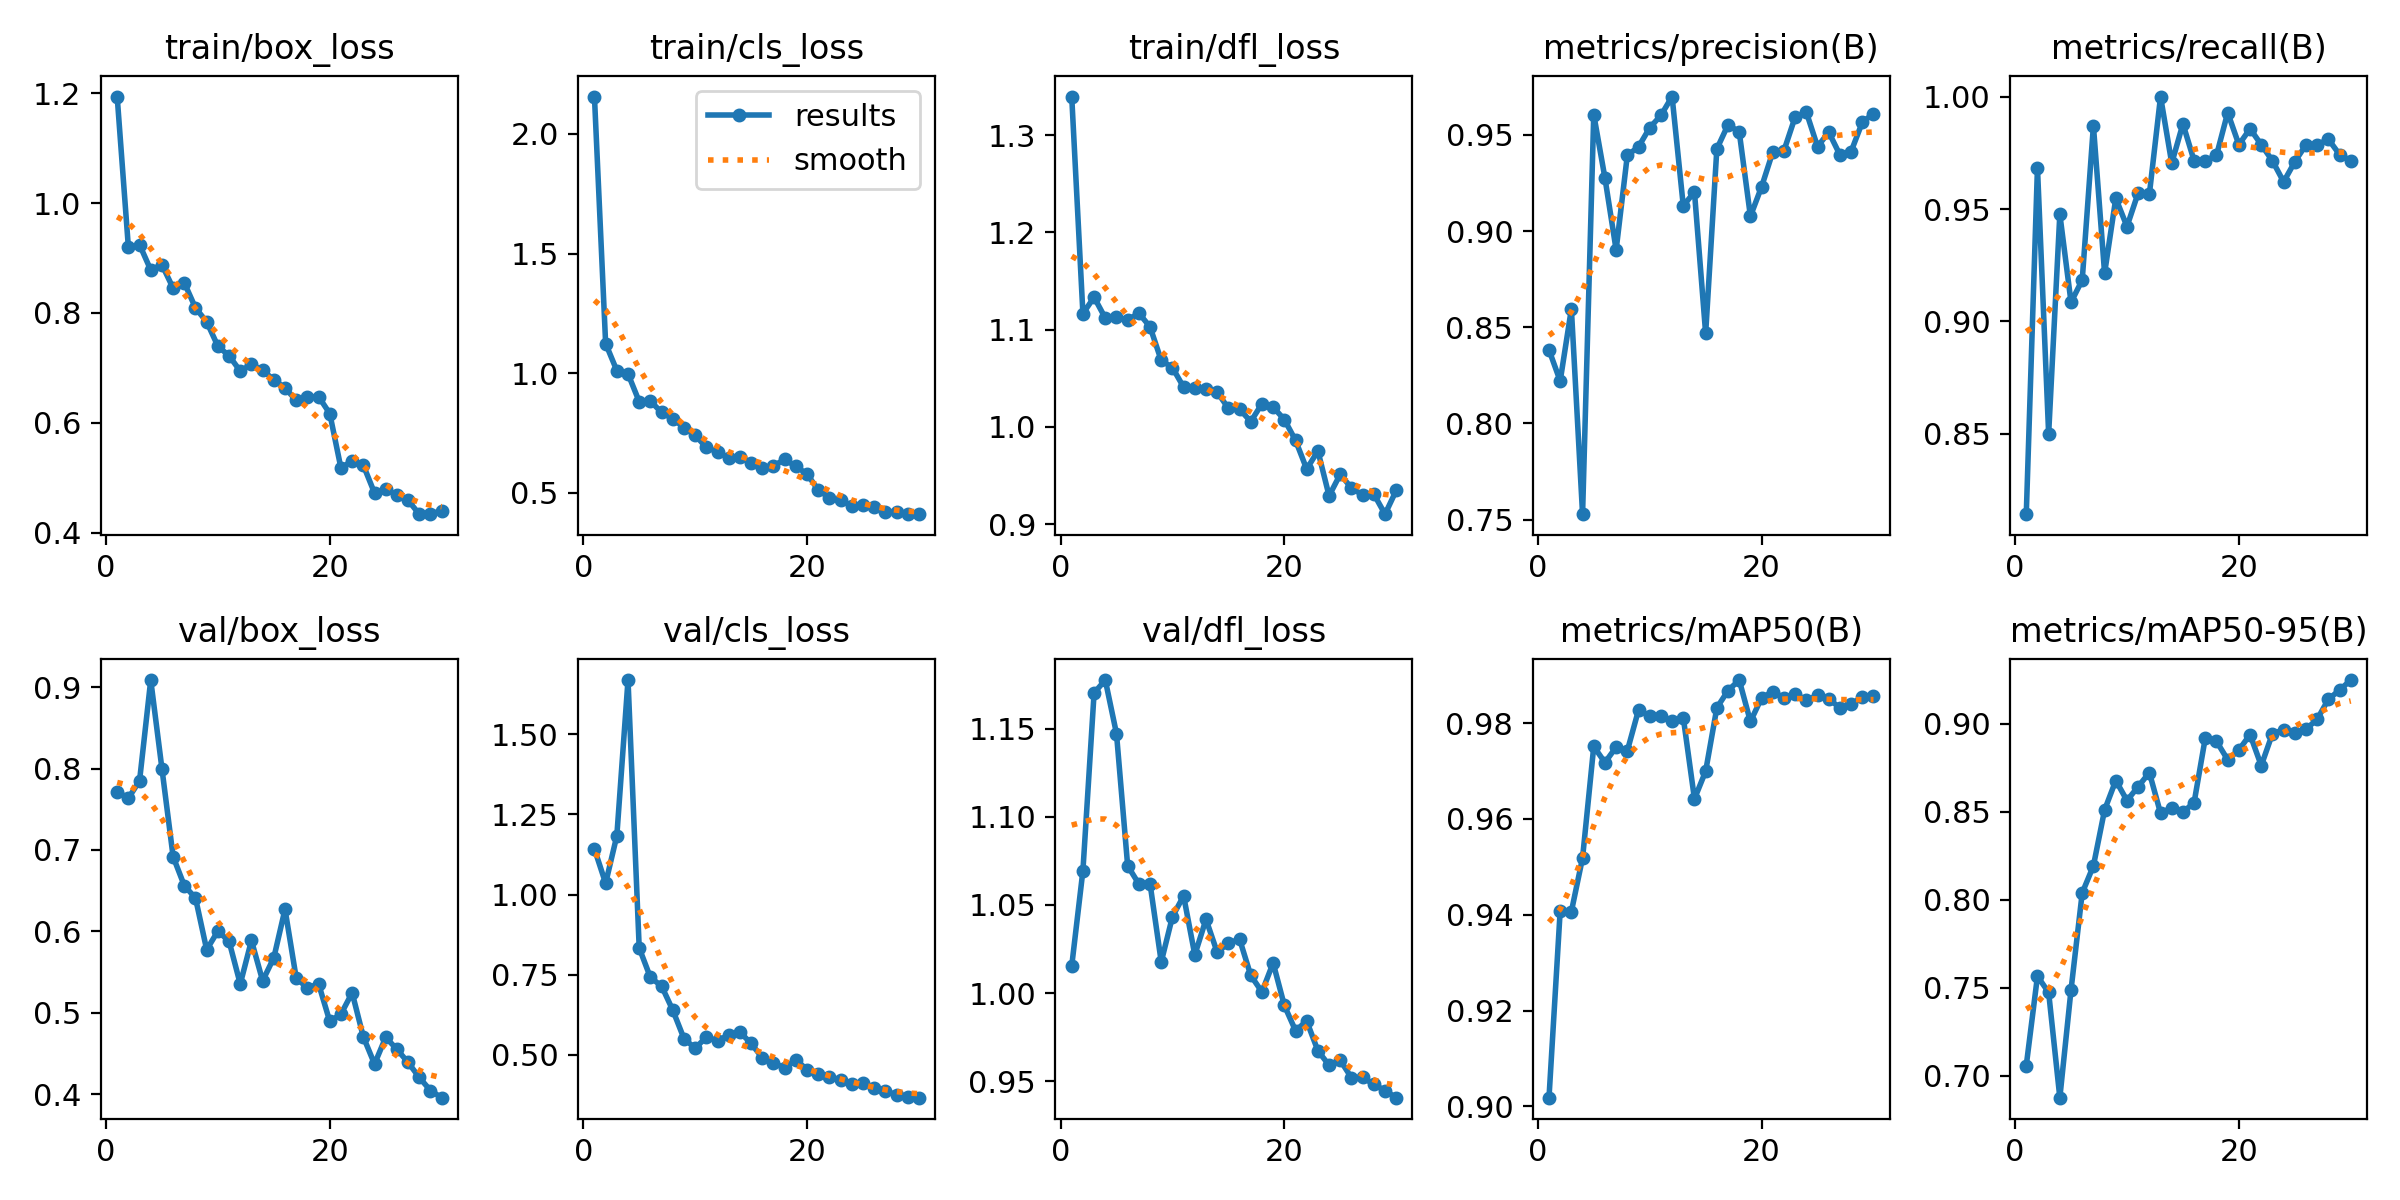

✅ File best.pt tersedia di: /content/runs/detect/deteksi_alat_makan_train_auto/weights/best.pt


In [34]:
# ===============================
# 5️⃣ Tampilkan grafik hasil training
# ===============================
from IPython.display import display, Image
train_dir = "/content/runs/detect/deteksi_alat_makan_train_auto"

# Tampilkan grafik hasil training
if os.path.exists(os.path.join(train_dir, "results.png")):
    display(Image(filename=os.path.join(train_dir, "results.png")))
elif os.path.exists(os.path.join(train_dir, "results.csv")):
    df = pd.read_csv(os.path.join(train_dir, "results.csv"))
    plt.figure(figsize=(8,5))
    plt.plot(df["epoch"], df["train/box_loss"], label="Box Loss")
    plt.plot(df["epoch"], df["train/cls_loss"], label="Class Loss")
    plt.plot(df["epoch"], df["metrics/mAP50"], label="mAP50")
    plt.title("Training Performance")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("⚠️ File results.png atau results.csv tidak ditemukan di:", train_dir)

# Cek file best.pt
best_model_path = os.path.join(train_dir, "weights", "best.pt")
if os.path.exists(best_model_path):
    print(f"✅ File best.pt tersedia di: {best_model_path}")
else:
    print("⚠️ File best.pt tidak ditemukan. Pastikan training selesai dan weights tersimpan.")